# FlashDiffusion demo
This is a demo showcasing degradation severity prediction and image reconstruction using the FlashDiffusion framework.
Before starting, make sure to follow the installation steps and download the necessary models and datasets.

/home/zalan/venvs/sevenc/lib/python3.8/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: /home/zalan/venvs/sevenc/lib/python3.8/site-packages/torchvision/image.so: undefined symbol: _ZN3c104cuda20CUDACachingAllocator12recordStreamERKNS_7DataPtrENS0_10CUDAStreamE
  warn(f"Failed to load image Python extension: {e}")


Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]


/home/zalan/venvs/sevenc/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/home/zalan/venvs/sevenc/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: /home/zalan/venvs/sevenc/lib/python3.8/site-packages/lpips/weights/v0.1/vgg.pth
making attention of type 'vanilla' with 512 in_channels


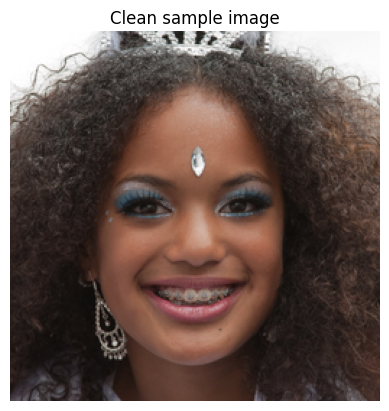

In [1]:
# Let's start with degradation severity prediction.
# A severity encoder takes a degraded image and predicts a scalar value proportional to the level of image degradation.
# We load a severity encoder trained to predict degradation level of images corrupted by Gaussian blur and additive noise.
from flash_diffusion import LDMSevEncoder
sev_enc = LDMSevEncoder.load_pretrained('checkpoints/sevenc_gblur_celeba256.ckpt')

# First, let's load a sample clean image.
from PIL import Image
from torchvision import transforms
import torch
from data_utils.data_transforms import SevEncInputTransform
from matplotlib import pyplot as plt

data_transform = SevEncInputTransform()
sample_img = Image.open('assets/sample.png').convert('RGB')
img_tensor = data_transform(sample_img)
plt.imshow(sample_img)
plt.title("Clean sample image")
plt.axis('off')
plt.show()

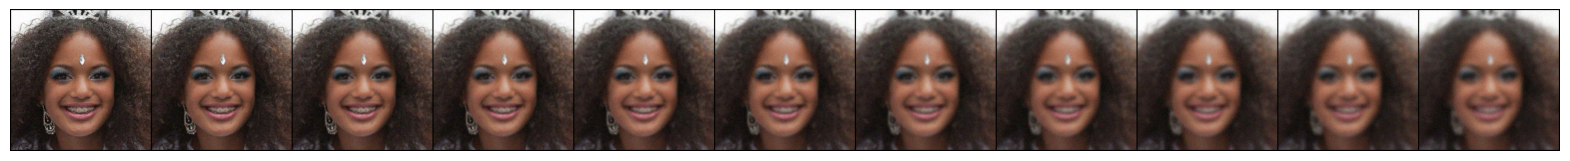

In [2]:
# Next we degrade the image with increasing level of Gaussian blur
import matplotlib.pyplot as plt
import torchvision
unnormalize = transforms.Compose([
    transforms.Normalize(mean=[-1, -1, -1], std=[1, 1, 1]),
    transforms.Normalize(mean=[0, 0, 0], std=[2.0, 2.0, 2.0]),
]) # unnormalization transform for plotting

# Degradation severity is parameterized by a scalar value in [0, 1].
# The higher the severity the more corrupted the image is.
# In this example we vary the width of the Gaussian blur kernel to parameterize severity.
severities = torch.linspace(0, 1, 11)
degraded_imgs = []
img_stack = [] # This is for plotting.
pred_severities = []
for sev in severities:
    degraded = sev_enc.fwd_operator(img_tensor, sev) + torch.randn_like(img_tensor) * 0.05
    degraded_imgs.append(degraded)
    img_stack.append(unnormalize(degraded).clip(0, 1))

degr_sequence = torch.cat(img_stack, dim=0)
grid = torchvision.utils.make_grid(degr_sequence, nrow=degr_sequence.shape[0])
plt.figure(figsize=(20, 5))
plt.imshow(grid.permute(1, 2, 0))
plt.axis('off')
plt.show()

Blur amount: 0.0%, Predicted severity: 0.16
Blur amount: 10.0%, Predicted severity: 0.17
Blur amount: 20.0%, Predicted severity: 0.19
Blur amount: 30.0%, Predicted severity: 0.21
Blur amount: 40.0%, Predicted severity: 0.24
Blur amount: 50.0%, Predicted severity: 0.26
Blur amount: 60.0%, Predicted severity: 0.28
Blur amount: 70.0%, Predicted severity: 0.31
Blur amount: 80.0%, Predicted severity: 0.33
Blur amount: 90.0%, Predicted severity: 0.36
Blur amount: 100.0%, Predicted severity: 0.37


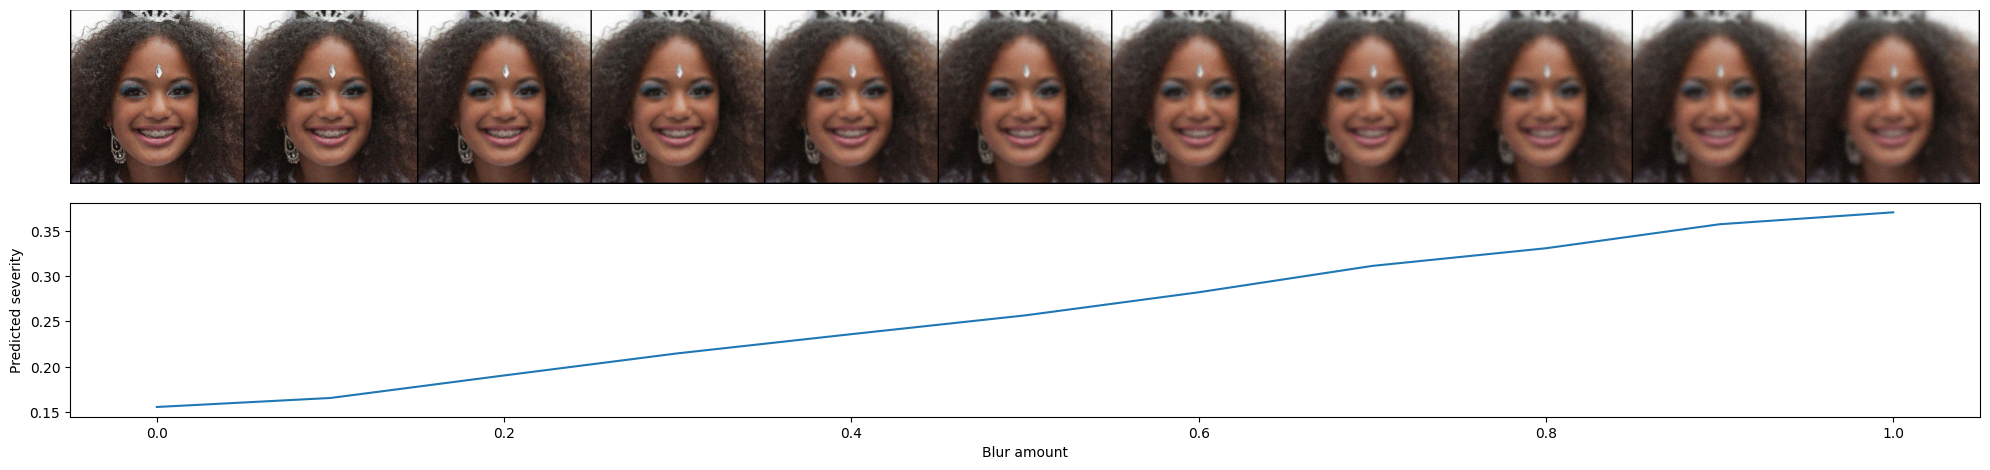

In [3]:
# We pass each degraded image through the severity encoder to predict the severity level.
pred_severities = []
for s, degraded in zip(severities, degraded_imgs):
    _, var = sev_enc(degraded)
    print(f"Blur amount: {s * 100:.1f}%, Predicted severity: {var.item():.2f}")
    pred_severities.append(var.detach().numpy())

# Plot the degraded image sequence and the predicted severities.
plt.figure(figsize=(20, 5))
plt.subplot(2, 1, 1)
plt.imshow(grid.permute(1, 2, 0))
plt.axis('off')
plt.subplot(2, 1, 2)
plt.plot(severities, pred_severities)
plt.xlabel('Blur amount')
plt.ylabel('Predicted severity')
plt.tight_layout()
plt.show()

# The predicted severity is an increasing function of the blur amount.

In [4]:
# The FlashDiffusion framework leverages the severity encoder to adapt the reconstruction process to the level of image degradation.
# Let's reconstruct a corrupted sample image.
from samplers import LDPS
from flash_diffusion import AdaptiveSampler
from scripts.utils import load_config_from_yaml

experiment_config = load_config_from_yaml('flash_configs/reconstruction_configs/demo.yaml') # Load config for Gaussian deblurring on FFHQ
flash_sampler = AdaptiveSampler(**experiment_config['adaptation'])

# We have to choose a baseline latent diffusion solver. FlashDiffusion wraps around the baseline solver accelerating it and improving reconstruction quality via adaptation. 
# We choose the naive LDPS solver here as a baseline for the sake of simplicity.
baseline_sampler = LDPS(experiment_config['data']['degradation_config'], **experiment_config['baseline'])

# Once the baseline solver is set up, we can attach it to the adaptive FlashDiffusion sampler.
flash_sampler.attach(baseline_sampler)

making attention of type 'vanilla' with 512 in_channels
Loading model from ldm/models/ldm/celeba256/model.ckpt


/home/zalan/venvs/sevenc/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:258: LightningDeprecationWarning: `pytorch_lightning.utilities.distributed.rank_zero_only` has been deprecated in v1.8.1 and will be removed in v1.10.0. You can import it from `pytorch_lightning.utilities` instead.
  rank_zero_deprecation(


LatentDiffusion: Running in eps-prediction mode
DiffusionWrapper has 274.06 M params.
Keeping EMAs of 370.
making attention of type 'vanilla' with 512 in_channels
Working with z of shape (1, 3, 64, 64) = 12288 dimensions.
making attention of type 'vanilla' with 512 in_channels
Training LatentDiffusion as an unconditional model.


Reconstruction: 100%|██████████| 82/82 [00:09<00:00,  8.86it/s]


Reconstruction with 10.0% severity completed in 82 steps. Acceleration compared to baseline: 12.2


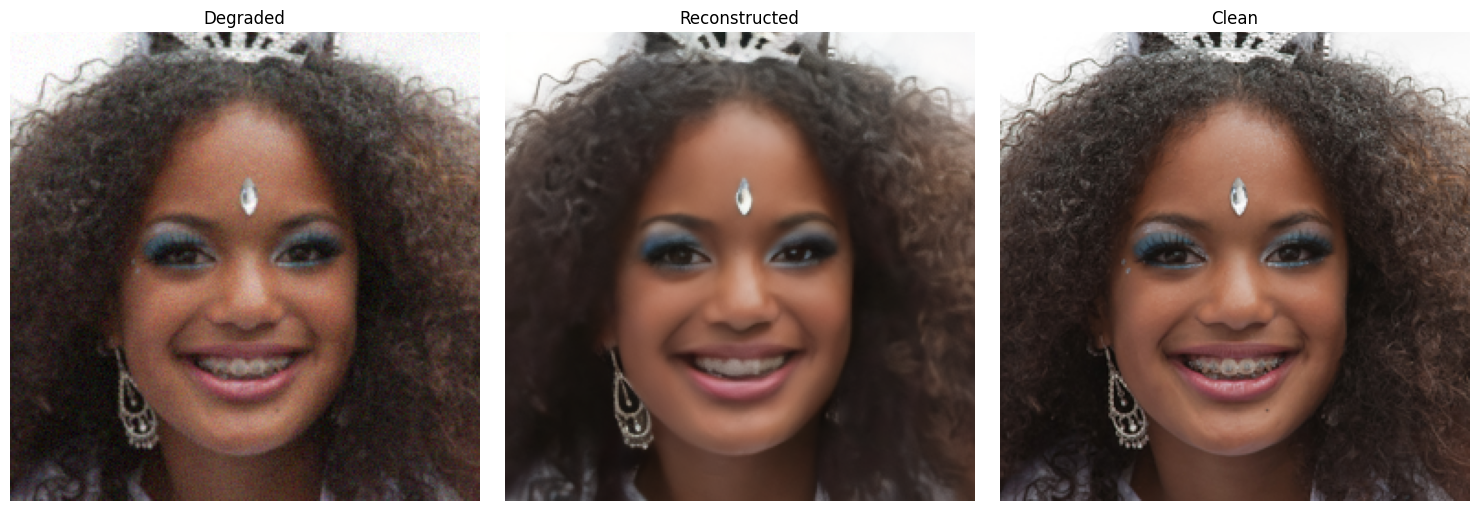

Reconstruction: 100%|██████████| 114/114 [00:12<00:00,  9.44it/s]


Reconstruction with 50.0% severity completed in 114 steps. Acceleration compared to baseline: 8.8


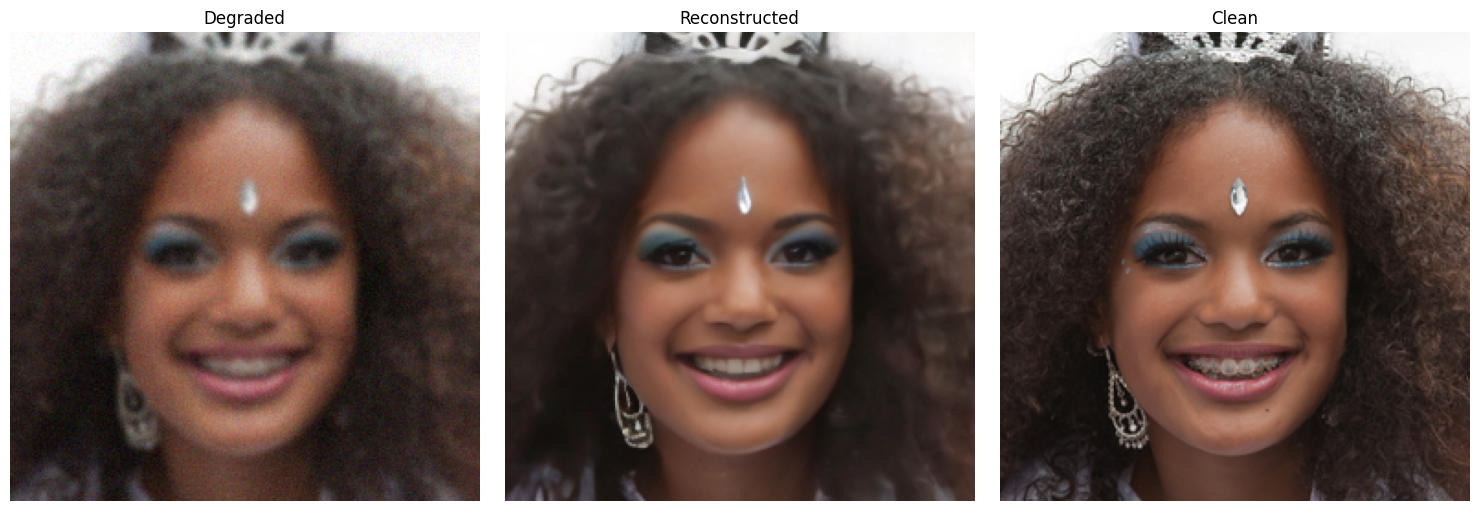

Reconstruction: 100%|██████████| 146/146 [00:15<00:00,  9.38it/s]


Reconstruction with 100.0% severity completed in 146 steps. Acceleration compared to baseline: 6.8


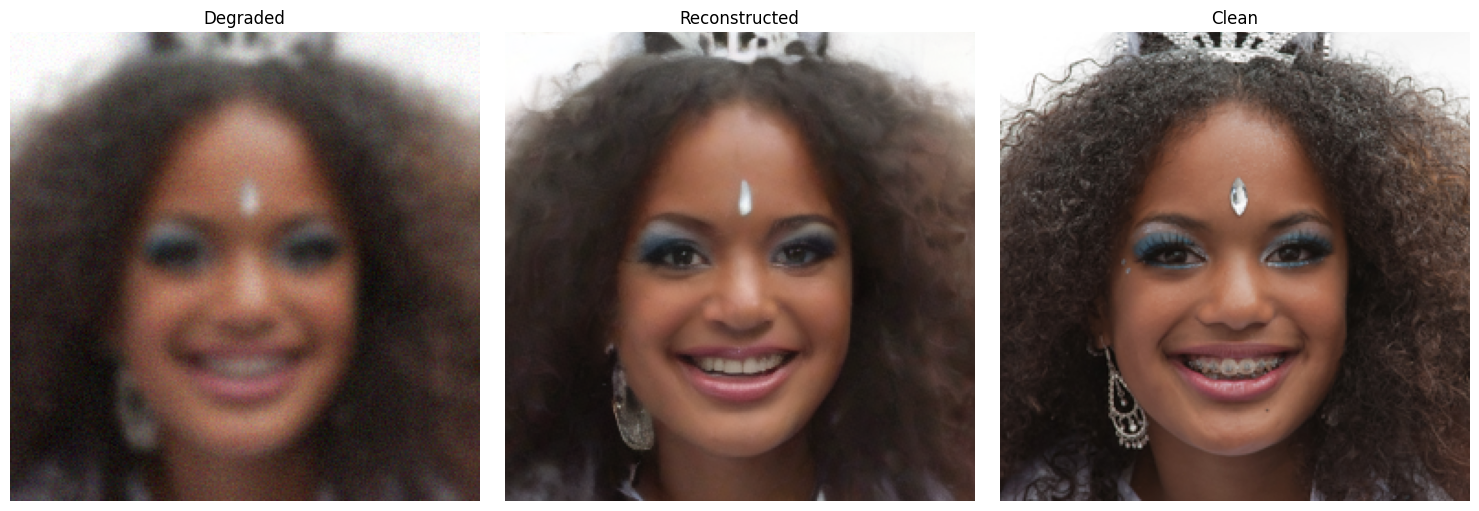

In [5]:
# We are ready to run the FlashDiffusion solver.
# We run reconstruction from different degradation levels.
# Inference cost (number of diffusion steps) is automatically adapted to the level of degradation on a sample-by-sample basis.
for idx in [1, 5, 10]:
    degraded = degraded_imgs[idx]
    severity = severities[idx]

    # Run reconstruction
    results = flash_sampler.run_single(degraded, severity)
    recon = results['recon']
    num_steps = results['t_start']

    print(f"Reconstruction with {severity * 100:.1f}% severity completed in {num_steps} steps. Acceleration compared to baseline: {1000 / num_steps:.1f}")

    # Visualize reconstruction
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 3, 1)
    plt.imshow(unnormalize(degraded).squeeze().permute(1, 2, 0).detach().cpu().numpy().clip(0.0, 1.0))
    plt.axis('off')
    plt.title('Degraded')
    plt.subplot(1, 3, 2)
    plt.imshow(unnormalize(recon).squeeze().permute(1, 2, 0).detach().cpu().numpy().clip(0.0, 1.0))
    plt.axis('off')
    plt.title('Reconstructed')
    plt.subplot(1, 3, 3)
    plt.imshow(sample_img)
    plt.axis('off')
    plt.title('Clean')
    plt.tight_layout()
    plt.show()